In [5]:
import pandas as pd
import numpy as np
import statsmodels.nonparametric.smoothers_lowess as statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.signal as signal
import scipy.stats as stats

# Load dinuc PSD data from the periodogram calc

In [6]:
dinuc_psd = pd.read_csv("SUM_PERIODOGRAM_TC_AG_autocorr_5-7.tab", sep="\t", names = ["pos", "value"], skiprows=1)
dinuc_psd["orig"] = "PSD sum"

In [7]:
dinuc_psd.head()

,pos,value,orig
0,350,1445.594412,PSD sum
1,385,1607.684803,PSD sum
2,420,1651.664718,PSD sum
3,455,1768.571365,PSD sum
4,490,1780.560552,PSD sum


# Calc a lowess smoothing

In [8]:
# I use lowess instead of loess because there is a lowess function. I couldnt find a loess one for python
lowess_model = statsmodels.lowess(endog=dinuc_psd["value"], exog=dinuc_psd["pos"], frac=0.025)

In [9]:
# add to the dataframe
temp_df = pd.DataFrame(lowess_model, columns=["pos", "value"])
temp_df["orig"] = "lowess"
dinuc_psd_low = dinuc_psd.append(temp_df)
dinuc_psd_low.head()

,pos,value,orig
0,350.0,1445.594412,PSD sum
1,385.0,1607.684803,PSD sum
2,420.0,1651.664718,PSD sum
3,455.0,1768.571365,PSD sum
4,490.0,1780.560552,PSD sum


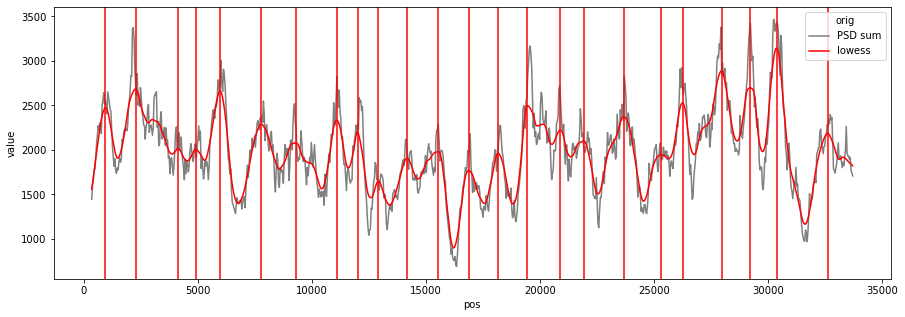

In [11]:
# plot
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x="pos", y="value", data=dinuc_psd_low, hue="orig", palette={"PSD sum":"grey", "lowess":"red"})

# plot local maxima lines
## I use argrelmax to search for local maxima, considering 10 points on either side
for i in signal.argrelmax(lowess_model[:,1], order=10)[0]:
    plt.axvline(lowess_model[i,0], color="red")

plt.savefig("dinucPSD_lowess_smooth.png", dpi=100, facecolor="w", transparent=False, bbox_inches="tight")
plt.savefig("dinucPSD_lowess_smooth.svg", dpi=100, facecolor="w", transparent=False, bbox_inches="tight")

# Load and process the DMS PSD data the same way

In [7]:
# read the psd data
dms_psd = pd.read_csv("../plots/paper_plots/python_notebooks/dms_psd_df.tab", sep="\t")
dms_psd_ts1 = dms_psd.loc[dms_psd["treatment"]=="Adts1"]
dms_psd = dms_psd.loc[dms_psd["treatment"]!="Adts1"] # exclude Adts1

In [8]:
### FIX the ts1 to get the same positions ###
suffix_df = pd.DataFrame()
suffix_df["specDens"] = [0]*91
suffix_df["genotype"] = "ts1"
suffix_df["mid"] = range(91)
suffix_df["treatment"] = "Adts1"

dms_psd_ts1_fixed = pd.DataFrame()
for sample in dms_psd_ts1["sample"].unique():
    temp_prefix = suffix_df
    temp_prefix["sample"] = sample
    temp_df = dms_psd_ts1.loc[dms_psd_ts1["sample"]==sample]
    f = pd.concat([temp_prefix, temp_df])
    
    f["mid"] = list(dms_psd.loc[dms_psd["sample"]=="AdWT_virus_DMS_1_footprint.wig", "mid"])
    
    dms_psd_ts1_fixed = dms_psd_ts1_fixed.append(f)

In [9]:
dms_psd.to_csv("../data/aligned/DMS_footprint/final_data/dms_psd_all_samples_aligned.tab", sep="\t", index=False)

<AxesSubplot:xlabel='mid', ylabel='specDens'>

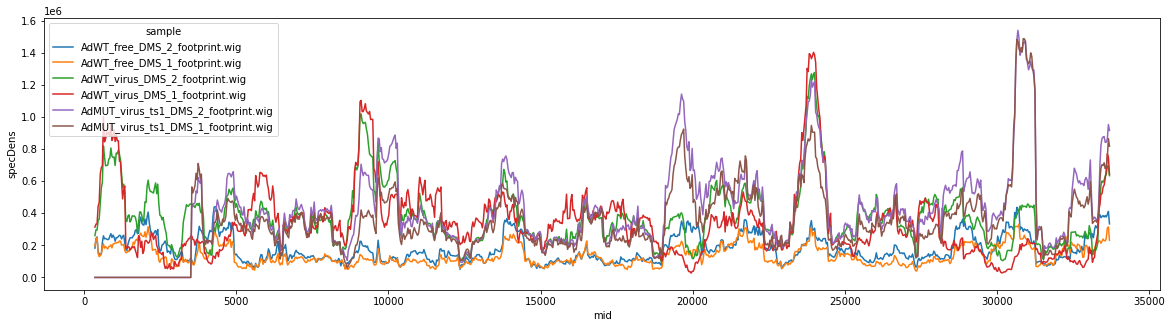

In [10]:
# sanity check #
dms_psd = dms_psd.append(dms_psd_ts1_fixed)
plt.subplots(figsize=(20,5))
sns.lineplot(x="mid", y="specDens", hue="sample", data=dms_psd)

In [11]:
# get a lowess estimation for every line
dms_lowess_psd = pd.DataFrame(dinuc_psd["pos"])
for sample in dms_psd["sample"].unique():
    temp_df = dms_psd.loc[dms_psd["sample"] == sample] # get the mean of genotype
    temp_df = temp_df.reset_index().rename(columns={"specDens":sample})
    dms_lowess_psd[sample+"_lowess"] = statsmodels.lowess(
            endog=temp_df[sample],
            exog=temp_df["mid"],
            frac=0.025
        )[:,1]

In [12]:
dms_lowess_psd

,pos,AdWT_free_DMS_2_footprint.wig_lowess,AdWT_free_DMS_1_footprint.wig_lowess,AdWT_virus_DMS_2_footprint.wig_lowess,AdWT_virus_DMS_1_footprint.wig_lowess,AdMUT_virus_ts1_DMS_2_footprint.wig_lowess,AdMUT_virus_ts1_DMS_1_footprint.wig_lowess
0,350,179631.821819,160457.502514,269489.171341,337307.654911,0.000000,0.000000
1,385,185090.863288,162625.422164,305664.802771,380036.673038,0.000000,0.000000
2,420,190527.089731,164847.807559,341458.557609,422143.516387,0.000000,0.000000
3,455,195908.111046,167078.659299,376819.298368,463595.017354,0.000000,0.000000
4,490,201192.507941,169270.066301,411719.299449,504395.750121,0.000000,0.000000
...,...,...,...,...,...,...,...
949,33565,389010.582448,236587.809907,625016.547981,638311.575738,861463.454252,728370.021364
950,33600,396999.605464,240170.634074,648691.109424,678668.086450,879925.026765,747403.328864
951,33635,404835.746106,243666.820735,672198.457411,719162.723406,898057.029948,766485.797422
952,33670,412525.834659,247077.879540,695516.409252,759781.656334,915878.982835,785650.095068


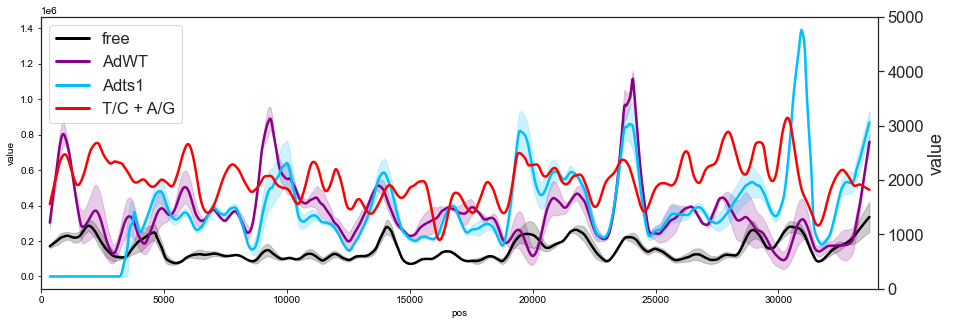

In [13]:
# plot all the smoothened curves together
fig, ax1 = plt.subplots(figsize=(15,5))

df = dms_lowess_psd.melt(id_vars="pos")
df.loc[["free" in x for x in df["variable"]],"genotype"] = "free"
df.loc[["AdWT_virus" in x for x in df["variable"]],"genotype"] = "AdWT"
df.loc[["ts1" in x for x in df["variable"]],"genotype"] = "Adts1"
df.to_csv("../data/aligned/DMS_footprint/final_data/DMSmet_PSD_lowess.tab", sep="\t", index=False)

sns.set(font_scale=1.5)
sns.set_style("ticks")

sns.lineplot(
    x="pos",
    y="value",
    hue="genotype",
    data=df,
    ax=ax1,
    palette={
        "free":"black",
        "AdWT":"darkmagenta",
        "Adts1":"deepskyblue"
    },
    linewidth=2.5
)

ax1.set_xlim(0,34062)

df = dinuc_psd_low.loc[dinuc_psd_low["orig"]=="lowess"]
df.to_csv("../data/aligned/DMS_footprint/final_data/dinuc_autocorr_PSD_lowess.tab", sep="\t", index=False)
ax2 = ax1.twinx()
sns.lineplot(
    x="pos",
    y="value",
    data=df,
    color="red",
    ax=ax2,
    linewidth=2.5
)

ax2.set_xlim(0,34062)
ax2.set_ylim(0, 5000)

custom_lines = [Line2D([0], [0], color="black", lw=3),
                Line2D([0], [0], color="darkmagenta", lw=3),
                Line2D([0], [0], color="deepskyblue", lw=3),
                Line2D([0], [0], color="red", lw=3)]

ax1.legend(custom_lines, ["free", "AdWT", "Adts1", "T/C + A/G"])


plt.savefig("lowess_smooth.png", dpi=100, facecolor="w", transparent=False, bbox_inches="tight")
plt.savefig("lowess_smooth.svg", dpi=100, facecolor="w", transparent=False, bbox_inches="tight")

In [14]:
df = dms_lowess_psd.melt(id_vars="pos")
df.loc[["free" in x for x in df["variable"]],"genotype"] = "free"
df.loc[["AdWT_virus" in x for x in df["variable"]],"genotype"] = "AdWT"
df.loc[["ts1" in x for x in df["variable"]],"genotype"] = "Adts1"
df.head()

,pos,variable,value,genotype
0,350,AdWT_free_DMS_2_footprint.wig_lowess,179631.821819,free
1,385,AdWT_free_DMS_2_footprint.wig_lowess,185090.863288,free
2,420,AdWT_free_DMS_2_footprint.wig_lowess,190527.089731,free
3,455,AdWT_free_DMS_2_footprint.wig_lowess,195908.111046,free
4,490,AdWT_free_DMS_2_footprint.wig_lowess,201192.507941,free


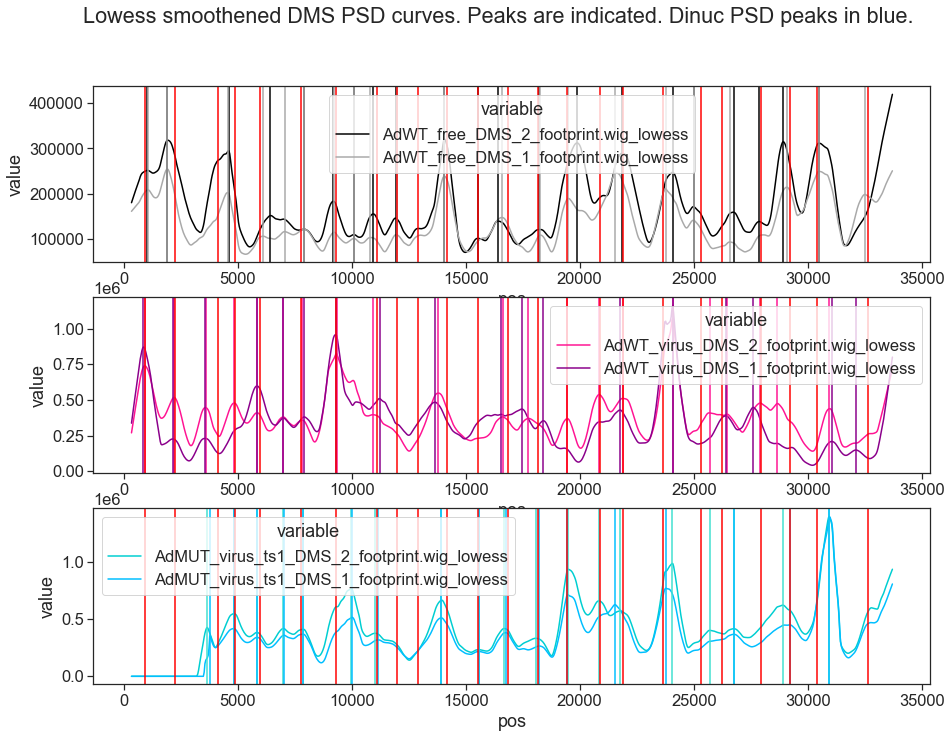

In [15]:
fig, ax1 = plt.subplots(3, 1, figsize=(15,11))

fig.suptitle("Lowess smoothened DMS PSD curves. Peaks are indicated. Dinuc PSD peaks in blue.")

df = dms_lowess_psd.melt(id_vars="pos")
df.loc[["free" in x for x in df["variable"]],"genotype"] = "free"
df.loc[["AdWT_virus" in x for x in df["variable"]],"genotype"] = "AdWT"
df.loc[["ts1" in x for x in df["variable"]],"genotype"] = "Adts1"

for i, geno in enumerate(df["genotype"].unique()):
    plot_df = df.loc[df["genotype"]==geno]
    sns.lineplot(
        x="pos",
        y="value",
        hue="variable",
        data=plot_df,
        palette = {
            "AdWT_free_DMS_1_footprint.wig_lowess": "darkgrey",
            "AdWT_free_DMS_2_footprint.wig_lowess": "black",
            "AdWT_virus_DMS_1_footprint.wig_lowess": "darkmagenta",
            "AdWT_virus_DMS_2_footprint.wig_lowess": "deeppink",
            "AdMUT_virus_ts1_DMS_1_footprint.wig_lowess":"deepskyblue",
            "AdMUT_virus_ts1_DMS_2_footprint.wig_lowess":"darkturquoise",
        },
        ax = ax1[i]
    )


    for sample in plot_df["variable"].unique():
        c = {
            "AdWT_free_DMS_1_footprint.wig_lowess": "darkgrey",
            "AdWT_free_DMS_2_footprint.wig_lowess": "black",
            "AdWT_virus_DMS_1_footprint.wig_lowess": "darkmagenta",
            "AdWT_virus_DMS_2_footprint.wig_lowess": "deeppink",
            "AdMUT_virus_ts1_DMS_1_footprint.wig_lowess":"deepskyblue",
            "AdMUT_virus_ts1_DMS_2_footprint.wig_lowess":"turquoise"
        }[sample]
        for j in signal.argrelmax(np.array(dms_lowess_psd[sample]), order=10)[0]:
            ax1[i].axvline(dms_lowess_psd.loc[j,"pos"], color=c)

# add the dinuc lowess and peaks     
# ax2 = ax1.twinx()
# sns.lineplot(x="pos", y="value", data=dinuc_psd_low, hue="orig")
for i in signal.argrelmax(lowess_model[:,1], order=10)[0]:
    ax1[0].axvline(lowess_model[i,0], color="red")
    ax1[1].axvline(lowess_model[i,0], color="red")
    ax1[2].axvline(lowess_model[i,0], color="red")
    
    
plt.savefig("peaks_lowess_AdWT_ts1_dinuc_psd.png", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)
plt.savefig("peaks_lowess_AdWT_ts1_dinuc_psd.svg", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)

## get the list of peak positions for both free and AdWT DMS data

In [16]:
peaks = {}
for sample in dms_psd["sample"].unique():    
    peaks[sample+"_lowess"] = []
    for i in signal.argrelmax(np.array(dms_lowess_psd[sample+"_lowess"]), order=10)[0]:
        peaks[sample+"_lowess"].append(dms_lowess_psd["pos"][i])

dinuc_lowess_peaks = []
for i in signal.argrelmax(np.array(dinuc_psd_low.loc[dinuc_psd_low["orig"]=="lowess"]["value"]), order=10)[0]:
    dinuc_lowess_peaks.append(np.array(dinuc_psd_low.loc[dinuc_psd_low["orig"]=="lowess"]["pos"])[i])

### Get the distances for every DMS PSD peak to the closest dinuc PSD peak

In [17]:
# iterate through all peaks of the DMS virus data
# and record the distance to the closest peak in the dinuc PSD data
# this way every peak in the DMSPSD is accounted for but some peaks from the dinucPSD may be counted twice
dist_dict = {}
for sample in peaks:
    dist_dict[sample] = []
    for peak in peaks[sample]:
        dist_dict[sample].append(np.min(abs(peak - dinuc_lowess_peaks)))

In [18]:
for sample in dist_dict:
    print(sample, " : ", np.mean(dist_dict[sample]))

AdWT_free_DMS_2_footprint.wig_lowess  :  255.0
AdWT_free_DMS_1_footprint.wig_lowess  :  236.66666666666666
AdWT_virus_DMS_2_footprint.wig_lowess  :  246.66666666666666
AdWT_virus_DMS_1_footprint.wig_lowess  :  326.6666666666667
AdMUT_virus_ts1_DMS_2_footprint.wig_lowess  :  274.4736842105263
AdMUT_virus_ts1_DMS_1_footprint.wig_lowess  :  245.0


The average distances for free and AdWT DMS PSD peaks to the closest dinuc PSD peak. AdWT peaks are closer than the free peaks, yet both are relatively close to one another.

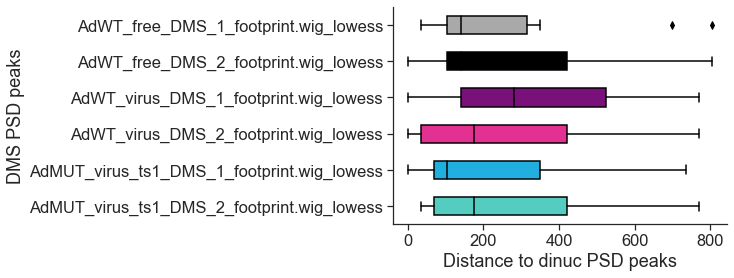

In [19]:
# plotting
plot_df = pd.DataFrame()
for sample in dist_dict:
    tdf = pd.DataFrame({"distance": dist_dict[sample]})
    tdf["sample"] = sample
    plot_df = plot_df.append(tdf)
    
sns.boxplot(
    y = "sample",
    x = "distance",
    data=plot_df,
    width = .5,
    order = [
        "AdWT_free_DMS_1_footprint.wig_lowess",
        "AdWT_free_DMS_2_footprint.wig_lowess",
        "AdWT_virus_DMS_1_footprint.wig_lowess",
        "AdWT_virus_DMS_2_footprint.wig_lowess",
        "AdMUT_virus_ts1_DMS_1_footprint.wig_lowess",
        "AdMUT_virus_ts1_DMS_2_footprint.wig_lowess"
    ],
    palette = {
        "AdWT_free_DMS_1_footprint.wig_lowess": "darkgrey",
        "AdWT_free_DMS_2_footprint.wig_lowess": "black",
        "AdWT_virus_DMS_1_footprint.wig_lowess": "darkmagenta",
        "AdWT_virus_DMS_2_footprint.wig_lowess": "deeppink",
        "AdMUT_virus_ts1_DMS_1_footprint.wig_lowess": "deepskyblue",
        "AdMUT_virus_ts1_DMS_2_footprint.wig_lowess": "turquoise"
    }
)
plt.xlabel("Distance to dinuc PSD peaks")
plt.ylabel("DMS PSD peaks")

sns.despine()

plt.savefig("samplesDMSPSDpeaks_distto_dinucPSCpeaks.svg", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)
plt.savefig("samplesDMSPSDpeaks_distto_dinucPSCpeaks.png", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)

## Leave the free DMS distances and combine the viral distances

median distance:  175.0
mean distance:  272.53333333333336


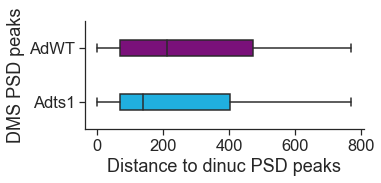

In [20]:
# plotting
plot_df = pd.DataFrame()
for sample in dist_dict:
    if "AdWT_virus" in sample:
        tdf = pd.DataFrame({"distance": dist_dict[sample]})
        tdf["genotype"] = "AdWT"
        tdf["sample"] = sample
        plot_df = plot_df.append(tdf)
    elif "AdMUT_virus" in sample:
        tdf = pd.DataFrame({"distance": dist_dict[sample]})
        tdf["genotype"] = "Adts1"
        tdf["sample"] = sample
        plot_df = plot_df.append(tdf)


fig, ax= plt.subplots(figsize=(5, 2))
sns.boxplot(
    y = "genotype",
    x = "distance",
    data=plot_df,
    width = .3,
    palette={
        "AdWT":"darkmagenta",
        "Adts1":"deepskyblue"
    }
)
plt.xlabel("Distance to dinuc PSD peaks")
plt.ylabel("DMS PSD peaks")

sns.despine()

print("median distance: ", plot_df["distance"].median())
print("mean distance: ", plot_df["distance"].mean())

plt.savefig("AdWTDMSPSDpeaks_distto_dinucPSCpeaks.svg", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)
plt.savefig("AdWTDMSPSDpeaks_distto_dinucPSCpeaks.png", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)

The Median of the dinuc PSD peak distance is 175. Most of AdWT DMS peaks are very close to the peaks of the dinuc autocorr PSD. This is evidence for the dinucleotide repeat pattern positioning the protein interaction on the virus.

However, the upper quartiles is rather high, indicating that for some peaks the distance is very far. These peaks appear in the virus DMS PSD data and are not explicable by the dinucleotide repeat pattern.

# Is the distance still that low, even with random dinuc peak positions?

In [21]:
# get the same number of random peaks
n_samplepeaks = len(dinuc_lowess_peaks)
random_samplepeaks = list(dinuc_psd_low["pos"].sample(n=n_samplepeaks, random_state=1994))

In [22]:
# get distance to the random peaks
dist_dict_random = {}
for sample in peaks:
    dist_dict_random[sample] = []
    for peak in peaks[sample]:
        dist_dict_random[sample].append(np.min(abs(peak - random_samplepeaks)))

In [23]:
# plotting dataframe
plot_df = pd.DataFrame()
for sample in dist_dict:
    tdf = pd.DataFrame({"distance": dist_dict[sample]})
    tdf["sample"] = sample
    if "free" in sample:
        tdf["genotype"] = "free to dinuc peaks"
    elif "AdWT_virus" in sample:
        tdf["genotype"] = "AdWT to dinuc peaks"
    else:
        tdf["genotype"] = "Adts1 to dinuc peaks"
    plot_df = plot_df.append(tdf)
    tdf = pd.DataFrame({"distance": dist_dict_random[sample]})
    tdf["sample"] = sample
    if "free" in sample:
        tdf["genotype"] = "free to random peaks"
    elif "AdWT_virus" in sample:
        tdf["genotype"] = "AdWT to random peaks"
    else:
        tdf["genotype"] = "Adts1 to random peaks"
    plot_df = plot_df.append(tdf)

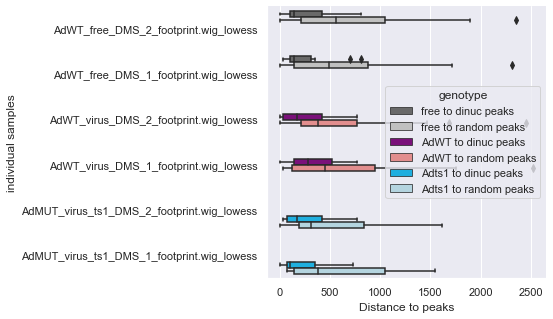

In [24]:
# sample-wise
sns.set(font_scale=1)

fig, ax= plt.subplots(figsize=(5, 5))
sns.boxplot(
    y = "sample",
    x = "distance",
    data=plot_df,
    width = .8,
    hue="genotype",
    palette={
        "free to dinuc peaks":"dimgrey",
        "free to random peaks":"silver",
        "AdWT to dinuc peaks":"darkmagenta",
        "AdWT to random peaks":"lightcoral",
        "Adts1 to dinuc peaks":"deepskyblue",
        "Adts1 to random peaks": "lightblue"
    }
)


plt.xlabel("Distance to peaks")
plt.ylabel("individual samples")
sns.despine()

plt.savefig("samplesDMSPSDpeaks_distto_dinucPSCpeaks_adnRandomPeaks.svg", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)
plt.savefig("samplesDMSPSDpeaks_distto_dinucPSCpeaks_adnRandomPeaks.png", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)

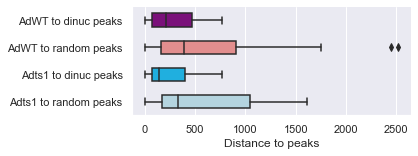

In [25]:
# subselect only AdWT
plot_df_adwt = plot_df.loc[plot_df["genotype"]!="free to dinuc peaks"]
plot_df_adwt = plot_df_adwt.loc[plot_df_adwt["genotype"]!="free to random peaks"]
       
fig, ax= plt.subplots(figsize=(5, 2))
sns.boxplot(
    y = "genotype",
    x = "distance",
    data=plot_df_adwt,
    width = .5,
    palette={
        "AdWT to dinuc peaks":"darkmagenta",
        "AdWT to random peaks":"lightcoral",
        "Adts1 to dinuc peaks":"deepskyblue",
        "Adts1 to random peaks": "lightblue"
    }
)
plt.xlabel("Distance to peaks")
plt.ylabel("")

sns.despine()


plt.savefig("AdWTDMSPSDpeaks_distto_dinucPSCpeaks_andRandomPeaks.svg", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)
plt.savefig("AdWTDMSPSDpeaks_distto_dinucPSCpeaks_andRandomPeaks.png", dpi=100, bbox_inches="tight", facecolor="w", transparent=False)

In [26]:
t, p = stats.ttest_ind(
    plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to dinuc peaks"]["distance"],
    plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to random peaks"]["distance"]
)
print("Mean of AdWT peaks to dinuc peaks: {}bp with n={}".format(plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to dinuc peaks"]["distance"].mean(), len(plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to dinuc peaks"]["distance"])))
print("Mean of AdWT peaks to random peaks: {}bp with n={}".format(plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to random peaks"]["distance"].mean(), len(plot_df_adwt.loc[plot_df_adwt["genotype"]=="AdWT to random peaks"]["distance"])))
print("independent two-sample ttest with pvalue of {}".format(round(p,4)))

Mean of AdWT peaks to dinuc peaks: 283.5897435897436bp with n=39
Mean of AdWT peaks to random peaks: 633.5897435897435bp with n=39
independent two-sample ttest with pvalue of 0.0023


In [27]:
t, p = stats.ttest_ind(
    plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to dinuc peaks"]["distance"],
    plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to random peaks"]["distance"]
)
print("Mean of Adts1 peaks to dinuc peaks: {}bp with n={}".format(plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to dinuc peaks"]["distance"].mean(), len(plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to dinuc peaks"]["distance"])))
print("Mean of Adts1 peaks to random peaks: {}bp with n={}".format(plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to random peaks"]["distance"].mean(), len(plot_df_adwt.loc[plot_df_adwt["genotype"]=="Adts1 to random peaks"]["distance"])))
print("independent two-sample ttest with pvalue of {}".format(round(p,4)))

Mean of Adts1 peaks to dinuc peaks: 260.55555555555554bp with n=36
Mean of Adts1 peaks to random peaks: 562.9166666666666bp with n=36
independent two-sample ttest with pvalue of 0.0022


In [28]:
for sample in dist_dict:
    print(sample, ": number of peaks = {}".format(len(dist_dict[sample])))

AdWT_free_DMS_2_footprint.wig_lowess : number of peaks = 21
AdWT_free_DMS_1_footprint.wig_lowess : number of peaks = 21
AdWT_virus_DMS_2_footprint.wig_lowess : number of peaks = 21
AdWT_virus_DMS_1_footprint.wig_lowess : number of peaks = 18
AdMUT_virus_ts1_DMS_2_footprint.wig_lowess : number of peaks = 19
AdMUT_virus_ts1_DMS_1_footprint.wig_lowess : number of peaks = 17
